## CS310 Natural Language Processing
## Assignment 4. Long Short Term Memory (LSTM) Network for Named Entity Recognition (NER)

**Total points**: 50 + (10 bonus)

In this assignment, you will implement a Long Short Term Memory (LSTM) network for Named Entity Recognition (NER). 

Re-use the code in Lab 5.

# Maximum entropy Markov model

### 0. Import Necessary Libraries

In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import re
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle

from utils import Indexer, read_ner_data_from_connl, get_batch

from metrics import MetricsHandler


In [49]:
torch.manual_seed(42)
np.random.seed(42)

os.environ["CUDA_VISIBLE_DEVICES"] = "4" 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")

DATA_DIR = '/home/stu_12310401/nlp/SUSTech-NLP25/Ass4/data'
GLOVE_PATH = '/home/stu_12310401/nlp/SUSTech-NLP25/Ass4/glove.6B.100d.txt'

BATCH_SIZE = 128
EMBEDDING_DIM = 100
TAG_EMBEDDING_DIM = 50
HIDDEN_DIM = 256
NUM_LAYERS = 2
DROPOUT = 0.5
LEARNING_RATE = 0.001
NUM_EPOCHS = 10

使用设备: cuda


In [50]:
class NERDataset(Dataset):
    def __init__(self, sentences, tags, word_to_idx, tag_to_idx):
        self.sentences = sentences
        self.tags = tags
        self.word_to_idx = word_to_idx
        self.tag_to_idx = tag_to_idx
        
    def __len__(self):
        return len(self.sentences)
    
    def __getitem__(self, idx):
        words = self.sentences[idx]
        tags = self.tags[idx]
        
        word_idxs = [self.word_to_idx.get(word.lower(), self.word_to_idx['<UNK>']) for word in words]
        tag_idxs = [self.tag_to_idx[tag] for tag in tags]
        
        return torch.tensor(word_idxs), torch.tensor(tag_idxs)

In [51]:
def build_vocab(sentences, tags, min_freq=1):
    word_counts = Counter()
    for sentence in sentences:
        word_counts.update([word.lower() for word in sentence])
    
    word_to_idx = {'<PAD>': 0, '<UNK>': 1}
    for word, count in word_counts.items():
        if count >= min_freq:
            word_to_idx[word] = len(word_to_idx)
    
    tag_counts = Counter()
    for sentence_tags in tags:
        tag_counts.update(sentence_tags)
    
    tag_to_idx = {'<PAD>': 0}
    for tag in tag_counts:
        tag_to_idx[tag] = len(tag_to_idx)
    
    return word_to_idx, tag_to_idx

In [52]:
def load_glove_embeddings(glove_path, word_to_idx, embedding_dim=100):
    """加载预训练的GloVe词向量"""
    embeddings = np.random.uniform(-0.25, 0.25, (len(word_to_idx), embedding_dim))
    embeddings[0] = np.zeros(embedding_dim)
    
    word_count = 0
    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in tqdm(f, desc="加载GloVe词向量"):
            values = line.split()
            word = values[0]
            if word.lower() in word_to_idx:
                vector = np.array(values[1:], dtype='float32')
                embeddings[word_to_idx[word.lower()]] = vector
                word_count += 1
    
    print(f"加载了 {word_count}/{len(word_to_idx)} 个词的预训练词向量")
    return torch.FloatTensor(embeddings)

In [53]:
def collate_fn(batch):
    batch.sort(key=lambda x: len(x[0]), reverse=True)
    sentences, tags = zip(*batch)
    
    lengths = [len(s) for s in sentences]
    max_len = max(lengths)
    
    padded_sentences = torch.zeros(len(sentences), max_len).long()
    padded_tags = torch.zeros(len(sentences), max_len).long()
    
    for i, (sentence, tag) in enumerate(zip(sentences, tags)):
        end = lengths[i]
        padded_sentences[i, :end] = sentence[:end]
        padded_tags[i, :end] = tag[:end]
    
    return padded_sentences, padded_tags, torch.tensor(lengths)

In [54]:
def load_data(file_path):
    #重新写了一个读取数据的函数，直接用utils的读取数据有点问题
    sentences = []
    tags = []
    
    sentence = []
    sentence_tags = []
    
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if line == '' or line.startswith('-DOCSTART-'):
                if sentence:
                    sentences.append(sentence)
                    tags.append(sentence_tags)
                    sentence = []
                    sentence_tags = []
            else:
                parts = line.split()
                if len(parts) >= 4:  
                    word = parts[0]
                    tag = parts[3]
                    sentence.append(word)
                    sentence_tags.append(tag)
    
    if sentence:
        sentences.append(sentence)
        tags.append(sentence_tags)
    
    return sentences, tags

### 1. Build the Model

In [55]:
class BiLSTM_MEMM_NER(nn.Module):
    def __init__(self, vocab_size, tag_size, embedding_dim, hidden_dim, tag_embedding_dim, num_layers, dropout, pretrained_embeddings=None):
        super(BiLSTM_MEMM_NER, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        if pretrained_embeddings is not None:
            self.embedding.weight = nn.Parameter(pretrained_embeddings)
        
        self.tag_embedding = nn.Embedding(tag_size, tag_embedding_dim)

        self.lstm = nn.LSTM(embedding_dim, 
                           hidden_dim // 2,  
                           num_layers=num_layers, 
                           bidirectional=True,
                           batch_first=True,
                           dropout=dropout if num_layers > 1 else 0)
        
        # MEMM层
        self.fc = nn.Linear(hidden_dim + tag_embedding_dim, tag_size)
        self.dropout = nn.Dropout(dropout)
        
        self.tag_size = tag_size
        self.hidden_dim = hidden_dim
        self.tag_embedding_dim = tag_embedding_dim
    
    def forward(self, x, lengths, tags=None, teacher_forcing_ratio=0.5):
        batch_size = x.size(0)
        max_len = x.size(1)
        
        embedded = self.dropout(self.embedding(x))
        
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True)
        outputs, _ = self.lstm(packed)
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs, batch_first=True)
        outputs = self.dropout(outputs)
        
        logits = torch.zeros(batch_size, max_len, self.tag_size).to(x.device)
        
        prev_tags = torch.zeros(batch_size).long().to(x.device)
        
        for t in range(max_len):
            valid_batch_mask = (t < lengths).float().unsqueeze(1)
            
            prev_tag_embedding = self.tag_embedding(prev_tags)
            
            combined = torch.cat([outputs[:, t], prev_tag_embedding], dim=1)
            
            current_logits = self.fc(combined)
            logits[:, t] = current_logits
            
            if tags is not None and torch.rand(1).item() < teacher_forcing_ratio:
                prev_tags = tags[:, t]
            else:
                _, prev_tags = torch.max(current_logits, dim=1)
                
            prev_tags = prev_tags * valid_batch_mask.squeeze(1).long()
        
        return logits

### 2. Train and Evaluate

In [56]:
def train_memm(model, train_loader, optimizer, criterion, device, teacher_forcing_ratio=0.5):
    model.train()
    total_loss = 0
    
    for sentences, tags, lengths in tqdm(train_loader, desc="训练"):
        sentences = sentences.to(device)
        tags = tags.to(device)
        lengths = lengths.to(device)
        
        optimizer.zero_grad()
        logits = model(sentences, lengths, tags, teacher_forcing_ratio)
        
        loss = 0
        for i in range(logits.size(0)):
            loss += criterion(logits[i, :lengths[i]], tags[i, :lengths[i]])
        loss /= logits.size(0)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(train_loader)

In [57]:
def evaluate_memm(model, data_loader, tag_to_idx, idx_to_tag, metrics_handler, device):
    model.eval()
    metrics_handler = MetricsHandler(classes=list(tag_to_idx.keys()))
    
    with torch.no_grad():
        for sentences, tags, lengths in tqdm(data_loader, desc="评估"):
            sentences = sentences.to(device)
            tags = tags.to(device)
            lengths = lengths.to(device)
            
            logits = model(sentences, lengths, teacher_forcing_ratio=0.0)
            
            for i in range(logits.size(0)):
                length = lengths[i]
                logits_i = logits[i, :length]
                tags_i = tags[i, :length]
                
                _, predicted = torch.max(logits_i, dim=1)
                
                pred_tags = [idx_to_tag[idx.item()] for idx in predicted]
                true_tags = [idx_to_tag[idx.item()] for idx in tags_i]
                
                metrics_handler.update(pred_tags, true_tags)
    
    metrics_handler.collect()
    metrics = metrics_handler.get_metrics()
    
    f1_scores = metrics["F1-score"]
    latest_f1 = f1_scores[-1] if f1_scores else 0.0
    
    return {"f1": latest_f1, "metrics": metrics}

In [58]:
from utils import get_tag_indices_from_scores
from metrics import MetricsHandler

labels_str = ['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC']
labels_int = list(range(len(labels_str)))
train_metrics = MetricsHandler(labels_int)

train_sentences, train_tags = load_data(os.path.join(DATA_DIR, 'train.txt'))
dev_sentences, dev_tags = load_data(os.path.join(DATA_DIR, 'dev.txt'))
test_sentences, test_tags = load_data(os.path.join(DATA_DIR, 'test.txt'))

word_to_idx, tag_to_idx = build_vocab(train_sentences, train_tags)
idx_to_tag = {idx: tag for tag, idx in tag_to_idx.items()}

TAGSET_SIZE = len(tag_to_idx)

print(f"TARGET SIZE: {TAGSET_SIZE}")

pretrained_embeddings = load_glove_embeddings(GLOVE_PATH, word_to_idx, EMBEDDING_DIM)

train_dataset = NERDataset(train_sentences, train_tags, word_to_idx, tag_to_idx)
dev_dataset = NERDataset(dev_sentences, dev_tags, word_to_idx, tag_to_idx)
test_dataset = NERDataset(test_sentences, test_tags, word_to_idx, tag_to_idx)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)


memm_model = BiLSTM_MEMM_NER(
    vocab_size=len(word_to_idx),
    tag_size=len(tag_to_idx),
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    tag_embedding_dim=TAG_EMBEDDING_DIM, 
    num_layers=NUM_LAYERS,
    dropout=DROPOUT,
    pretrained_embeddings=pretrained_embeddings
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=tag_to_idx['<PAD>'])
optimizer = optim.Adam(memm_model.parameters(), lr=0.0005)


metrics_handler = MetricsHandler(classes=list(range(TAGSET_SIZE)))


TARGET SIZE: 10


加载GloVe词向量: 400000it [00:02, 165525.61it/s]

加载了 18415/21011 个词的预训练词向量


In [59]:
print("开始MEMM模型训练...")
train_losses = []
dev_f1_scores = []

for epoch in range(NUM_EPOCHS):
    # 逐渐降低教师强制比例
    teacher_forcing_ratio = max(0.0, 1.0 - 0.1 * epoch)
    
    train_loss = train_memm(memm_model, train_loader, optimizer, criterion, device, teacher_forcing_ratio)
    train_losses.append(train_loss)
    
    dev_metrics = evaluate_memm(memm_model, dev_loader, tag_to_idx, idx_to_tag, metrics_handler, device)
    dev_f1 = dev_metrics['f1']
    dev_f1_scores.append(dev_f1)
    
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Loss: {train_loss:.4f}, Dev set F1: {dev_f1:.4f}, TF ratio: {teacher_forcing_ratio:.2f}")

torch.save({
    'model_state_dict': memm_model.state_dict(),
    'word_to_idx': word_to_idx,
    'tag_to_idx': tag_to_idx,
    'idx_to_tag': idx_to_tag,
    'hyperparams': {
        'embedding_dim': EMBEDDING_DIM,
        'hidden_dim': HIDDEN_DIM,
        'tag_embedding_dim': TAG_EMBEDDING_DIM,
        'num_layers': NUM_LAYERS,
        'dropout': DROPOUT
    }
}, 'bilstm_memm_ner_model.pt')

开始MEMM模型训练...


评估: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]
/home/stu_12310401/nlp/SUSTech-NLP25/Ass4/metrics.py:5: RuntimeWarning: invalid value encountered in scalar divide
  return x[1, 1]/(x[1, 1] + x[0, 1])
/home/stu_12310401/nlp/SUSTech-NLP25/Ass4/metrics.py:9: RuntimeWarning: invalid value encountered in scalar divide
  return x[1, 1] / (x[1, 0] + x[1, 1])
/home/stu_12310401/nlp/SUSTech-NLP25/Ass4/metrics.py:15: RuntimeWarning: invalid value encountered in scalar divide
  return ((1 + beta**2)*precision*recall)/(beta**2 * precision + recall)


Epoch 1/10, Loss: 0.9035, Dev set F1: 0.5435, TF ratio: 1.00


评估: 100%|██████████| 26/26 [00:03<00:00,  8.39it/s]


Epoch 2/10, Loss: 0.3602, Dev set F1: 0.5969, TF ratio: 0.90


评估: 100%|██████████| 26/26 [00:03<00:00,  8.49it/s]


Epoch 3/10, Loss: 0.2489, Dev set F1: 0.6914, TF ratio: 0.80


评估: 100%|██████████| 26/26 [00:03<00:00,  8.51it/s]


Epoch 4/10, Loss: 0.2066, Dev set F1: 0.7225, TF ratio: 0.70


评估: 100%|██████████| 26/26 [00:03<00:00,  8.41it/s]


Epoch 5/10, Loss: 0.1857, Dev set F1: 0.7379, TF ratio: 0.60


评估: 100%|██████████| 26/26 [00:03<00:00,  8.45it/s]


Epoch 6/10, Loss: 0.1707, Dev set F1: 0.7663, TF ratio: 0.50


评估: 100%|██████████| 26/26 [00:02<00:00, 10.30it/s]


Epoch 7/10, Loss: 0.1590, Dev set F1: 0.7640, TF ratio: 0.40


评估: 100%|██████████| 26/26 [00:02<00:00, 10.80it/s]


Epoch 8/10, Loss: 0.1506, Dev set F1: 0.7885, TF ratio: 0.30


评估: 100%|██████████| 26/26 [00:02<00:00, 10.74it/s]


Epoch 9/10, Loss: 0.1404, Dev set F1: 0.7858, TF ratio: 0.20


评估: 100%|██████████| 26/26 [00:02<00:00, 10.49it/s]


Epoch 10/10, Loss: 0.1338, Dev set F1: 0.8035, TF ratio: 0.10


### 3. Other Experiments

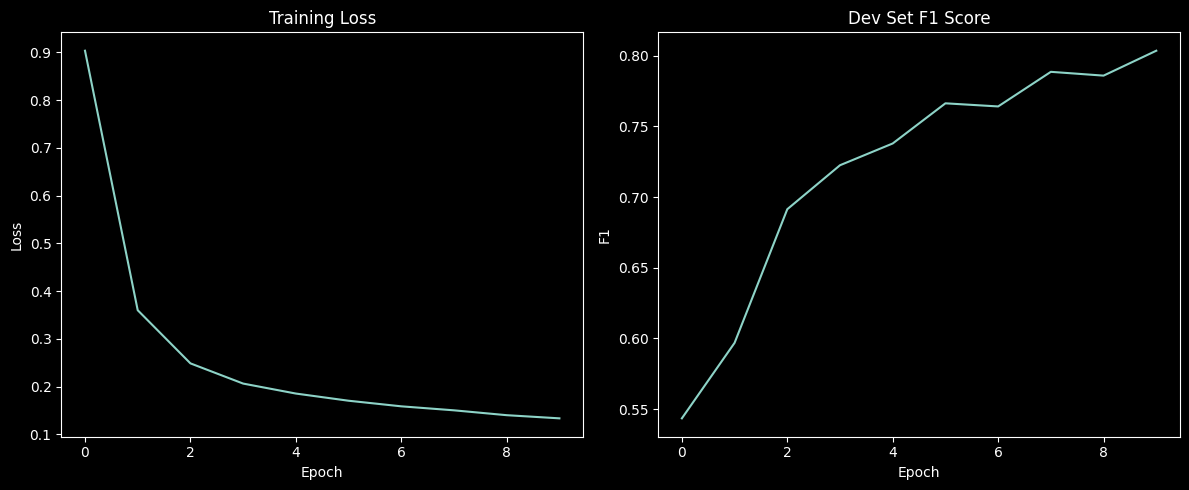

In [60]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(dev_f1_scores)
plt.title('Dev Set F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1')

plt.tight_layout()
plt.savefig('training_curves.png')
plt.show()